# RandomFprest implementation on Word2Vec 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc,roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV,RandomizedSearchCV
from sklearn.datasets import *
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve
from sklearn.cross_validation import cross_val_score
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import TimeSeriesSplit,KFold
from sklearn import cross_validation
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import parfit.parfit as pf
from sklearn.utils import shuffle
import random
import gensim
import warnings
warnings.filterwarnings('ignore')

# Reading the data from CSV

In [3]:
final_data=pd.read_csv('Amazon.csv')

# Sorting the Data based on Time

In [4]:
final_data.sort_values('Time',ascending=True)
final_data.head()

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


# Spliting the data into Train and Test

In [5]:
tscv=TimeSeriesSplit(n_splits=2)
for train_index,test_index in tscv.split(final_data):
    print("Train:", train_index,"Test:", test_index)
    train_data,test_data = final_data.iloc[train_index],final_data.iloc[test_index]

Train: [     0      1      2 ..., 121388 121389 121390] Test: [121391 121392 121393 ..., 242778 242779 242780]
Train: [     0      1      2 ..., 242778 242779 242780] Test: [242781 242782 242783 ..., 364168 364169 364170]


In [6]:
#Training data
train_data=shuffle(train_data)
reviews=train_data['Score']
reviews=reviews[0:70000]
train_data=train_data[0:70000]

In [7]:
#Test data
test_data=shuffle(test_data)
test_review=test_data['Score']
test_review=test_review[0:30000]
test_data=test_data[0:30000]

# Applying Word2vec to featurize the text

In [8]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'by', 'than', 'is', "that'll", 'but', "don't", 'those', 'he', 'each', 'as', 'be', 'yourselves', 'she', 'being', 'can', 'of', 'when', "should've", 'just', 'ain', "doesn't", 'nor', 'didn', "haven't", 'both', 'or', 'having', 'mustn', 've', 'mightn', 'o', 'further', 'above', 'doing', 'doesn', 'until', 'against', 'aren', 'them', 'ours', 'our', "you've", 'we', 'herself', "she's", 'before', 'haven', 'too', 'ma', 'out', 'few', 'some', "hasn't", 'have', 'are', 'only', 'then', 'whom', "mightn't", 'at', "couldn't", 'who', 'how', 'after', 'its', 'an', "hadn't", 'themselves', 'under', 'my', 'here', 'same', 'won', 'again', 'the', 'wouldn', 'on', 'so', "weren't", 'during', 'hasn', 'now', 'about', 'between', 'into', 'up', 'own', 'off', 'don', 'you', 'needn', 'has', 'most', 'this', "wasn't", "shan't", 'myself', 'any', 'which', 'while', 'his', 'y', 'that', 'where', 's', 'himself', 'these', 'over', 'weren', 'through', 'why', 'me', 'theirs', 'i', 'him', 'had', 'below', 'shouldn', "aren't", 'no', 'will', 

In [9]:
i=0
list_of_sent_train=[]
for sent in train_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [10]:
i=0
list_of_sent_test=[]
for sent in test_data['CleanText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [11]:
w2v_model_train=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=200,workers=4)
w2v_model_test=gensim.models.Word2Vec(list_of_sent_test,min_count=5,size=200,workers=4)

In [12]:
sent_vectors_train=[]
for sent in list_of_sent_train:
    sent_vec=np.zeros(200)
    #print(sent_vec)
    cnt_words=0;
    for word in sent:
        try:
            vec=w2v_model_train.wv[word]
            #print(vec)
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))      

70000
200


In [13]:
sent_vectors_test=[]
for sent in list_of_sent_test:
    sent_vec=np.zeros(200)
    #print(sent_vec)
    cnt_words=0;
    for word in sent:
        try:
            vec=w2v_model_test.wv[word]
            #print(vec)
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))      

30000
200


In [14]:
sent_vectors_train_array=np.array(sent_vectors_train)
sent_vectors_train_array=np.nan_to_num(sent_vectors_train_array)

sent_vectors_test_array=np.array(sent_vectors_test)
sent_vectors_test_array=np.nan_to_num(sent_vectors_test_array)

In [15]:
cv_data=sent_vectors_train_array[40000:70000]

In [18]:
cv_review=reviews[40000:70000]

# Finding the optimal number of estimators

[0.87100056925932245, 0.88169981431109046, 0.88209940324067448, 0.88226652546665107, 0.88189945885179166, 0.88206656991850774, 0.88113289203328427, 0.88163319214072489, 0.88223263658510775, 0.88153288097032012]

The optimal number of models is 70.


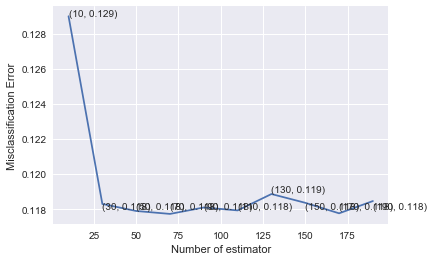

the misclassification error for each i value is :  [ 0.129  0.118  0.118  0.118  0.118  0.118  0.119  0.118  0.118  0.118]


In [19]:
estimator = list(range(10,210,20))
cv_scores = []

# perform 10-fold cross validation
for i in estimator:
    rfc = RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(rfc,cv_data,cv_review, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_num = estimator[MSE.index(min(MSE))]
print('\nThe optimal number of models is %d.' % optimal_num)

# plot misclassification error vs depth 
plt.plot(estimator, MSE)

for xy in zip(estimator, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of estimator')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each i value is : ", np.round(MSE,3))

# Finding the optimal depth by Keeping the number of estimators constant

[0.84923335661111365, 0.85063335670000273, 0.85476651250739033, 0.86029977952960512, 0.86526631321847935, 0.86976652465183624, 0.87309971379626439, 0.87503293609254862, 0.87686641398515719, 0.87969940309252626, 0.87913291417402761, 0.87949978084812375, 0.88046639199996934, 0.88033266982585234, 0.88016629201106955, 0.87973299194811028, 0.88083248094064603, 0.88196610322956703, 0.88119924761843493, 0.88146612541475466, 0.88076648096294241, 0.88163316984442619, 0.88093309208515824, 0.88249922545546955, 0.88236622549254362, 0.88246640327774861, 0.8801995364629116, 0.88053293643328912, 0.882199636607367]

The optimal number of depth is 26.


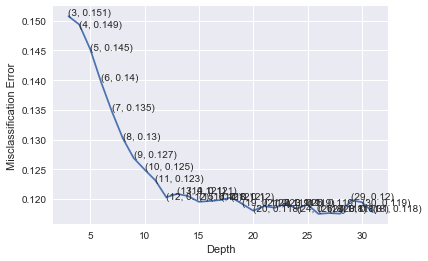

the misclassification error for each i value is :  [ 0.151  0.149  0.145  0.14   0.135  0.13   0.127  0.125  0.123  0.12
  0.121  0.121  0.12   0.12   0.12   0.12   0.119  0.118  0.119  0.119
  0.119  0.118  0.119  0.118  0.118  0.118  0.12   0.119  0.118]


In [63]:
depth = list(range(3,32))
cv_scores = []

# perform 10-fold cross validation
for i in depth:
    rfc = RandomForestClassifier(max_depth=i,n_estimators=70)
    scores = cross_val_score(rfc,cv_data,cv_review, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_i = depth[MSE.index(min(MSE))]
print('\nThe optimal number of depth is %d.' % optimal_i)

# plot misclassification error vs depth 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Depth')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each i value is : ", np.round(MSE,3))

# Apply the Random Forest with optimal hyperparameters

In [64]:
rfcl=RandomForestClassifier(n_estimators=70,max_depth=26)

In [65]:
rfcl.fit(sent_vectors_train_array,reviews)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=26, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Prediction and evaluation

In [66]:
predict=rfcl.predict(sent_vectors_test_array)

In [67]:
print(classification_report(test_review,predict))

             precision    recall  f1-score   support

          0       0.78      0.04      0.08      5010
          1       0.84      1.00      0.91     24990

avg / total       0.83      0.84      0.77     30000



In [68]:
confu_metric=confusion_matrix(test_review,predict)
print(confu_metric)

[[  224  4786]
 [   65 24925]]


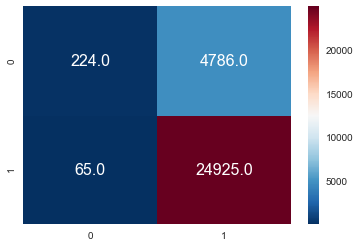

In [69]:
sns.heatmap(confu_metric,annot=True,fmt='.1f',annot_kws={"size": 16},cmap='RdBu_r')

# Test and Train metric

In [70]:
TP=confu_metric[1][1]
FP=confu_metric[0][1]
TN=confu_metric[0][0]
FN=confu_metric[1][0]

In [71]:
True_positive_rate=TP/(TP+FN) #It tells us when it is actually a Positive Review , How often does it predict Postive Review
print('TPR: ',True_positive_rate)

false_positive_rate=FP/(FP+TN) # It tells us that when the review is negative how often does it predict Positive Review
print('FPR: ',false_positive_rate)

specificity=TN/(TN+FP) #It tells us that When the review is negative ,how often does it predict negative review
print('Specificity: ',specificity)

precision=TP/(TP+FP) # It tells us all the reviews that model has predicted to be Positive how many are truly positive 
print('Precision: ',precision)

recall=TP/(TP+FN) # It tells us that from all the predicted postive reviews how many are actually postive review
print('Recall: ',recall)

f1_score=2*precision*recall/(precision+recall) #It is the weighted average of the Precision and Recall
print('F1Score: ',f1_score)

TPR:  0.997398959584
FPR:  0.955289421158
Specificity:  0.0447105788423
Precision:  0.838914880011
Recall:  0.997398959584
F1Score:  0.911317891812


# ROC Curve

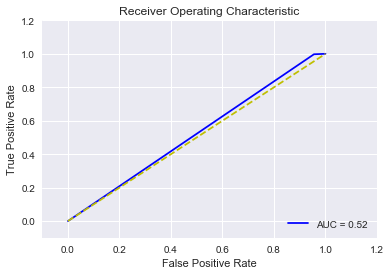

In [72]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,thresholds=roc_curve(test_review,predict)
roc_auc=auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'y--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Observation : 1.I have preprocessed and cleaned  the whole dataset and store in Amazon.csv file for the further use. That CSV contains all the data. 
2. Now We have cleaned data , So I have sorted the Whole data on the basic of the TimeStamp
3. Now I have splitted my whole Dataset into Training,Cross validation and Test datasets for My ML
4. I have taken the 70K sample from the Training purpose and 30K Sample for Testing purpose and another 30K for cross validation
5. Its time to convert our text into vectors . I have used word2vec to convert my text reviews into Vectors . 
   I have converted the Training Sample, Test sample individually

7. First I have used cross validation technique to find the optimal No. of estimators for my Random Forest
   then I have used cross validation technique to find the optimal No. of depth for my Random Forest
8. I have plot the curve between MSE and No. of depth
9. I have applied DecisionTreeClassifier() using best depth and estimator
10. I have predicted and evaluated the test data using classificationreport and confusion matrix
11. I have also found different test and train metric and on the basic of that I have drawn Roc cuve 

    

# Result comparision Between Word2Vec and Weightted tfidf

In [5]:
data={'Word2Vec':[0.8389,0.997,0.9113,0.52,0.9973,0.955,0.044],'Weighted Tfidf':[0.8350,0.9946,0.907,0.51,0.9946,0.9947,0.025]}

In [6]:
pd.DataFrame(data,index=['Precision','Recall','F1Score','ROC','TPR','FPR','Specificty'])

,Word2Vec,Weighted Tfidf
Precision,0.8389,0.8350
Recall,0.9970,0.9946
F1Score,0.9113,0.9070
ROC,0.5200,0.5100
TPR,0.9973,0.9946
FPR,0.9550,0.9947
Specificty,0.0440,0.0250
